# 115th U.S. Congress Composition and Voting Record - Analysis, vizualization and k-means clustering

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Libraries-and-Configuration" data-toc-modified-id="Libraries-and-Configuration-2">Libraries and Configuration</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3">Data</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-4">Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Demographic-Profile" data-toc-modified-id="Demographic-Profile-4.1">Demographic Profile</a></span></li><li><span><a href="#Partisan-Breakdown" data-toc-modified-id="Partisan-Breakdown-4.2">Partisan Breakdown</a></span></li></ul></li><li><span><a href="#k-Means-Clustering" data-toc-modified-id="k-Means-Clustering-5">k-Means Clustering</a></span><ul class="toc-item"><li><span><a href="#Senate" data-toc-modified-id="Senate-5.1">Senate</a></span></li><li><span><a href="#House-of-Representatives" data-toc-modified-id="House-of-Representatives-5.2">House of Representatives</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

## Introduction

**Background:** 

With the 2018 U.S. midterm elections right around the corner and the control of Congress at stake, the 115th U.S. Congress might soon drastically change. Indeed, the coming election features of the most __[diverse pool of candidates](https://www.nbcnews.com/politics/first-read/2018-candidate-diversity-goes-beyond-gender-n901956)__, from record numbers of women and LGBTQ candidates to unprecedented racial and religious diversity.

This project aims to analyze the composition and voting record of the 115th U.S. Congress on the eve of the 2018 midterm elections. 

**Goals:**
<ul>
    <li>Examine the 115th U.S. Congress' demographic profile;</li>
    <li>Inspect Congress' partisan composition;</li>
    <li>Determine whether members of Congress always vote according to party lines;</li>
    <li>Highlight moderate members of Congress.</li>
</ul>

## Libraries and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import shapely.geometry as sgeom
import geopandas
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.io import shapereader
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
# Seaborn styling options
sns.set_style('white')
sns.set_context(rc={'font.size':13, 'axes.titlesize':16, 'axes.labelsize':14, 'legend.fontsize':13,
                    'xtick.labelsize': 12, 'ytick.labelsize' : 12})
sns.set_palette('muted')
cmap = sns.color_palette('deep')

# Plot percentage labelling
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Center plots
from IPython.core.display import HTML
HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

## Data

Details about the data can be found in the __[data wrangling notebook](congress-votes-data-wrangling.ipynb)__.

In [3]:
# Senate voting record dataset
senate_df = pd.read_csv('data/clean_senate_votes.csv')

# Preview dataset
senate_df.head()

,chamber,member_id,last_name,first_name,party,state_code,state_id,1,2,3,...,555,556,557,558,559,560,561,562,563,564
0,Senate,41704,Strange,"Luther Johnson, III",R,AL,41,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,Senate,41705,Jones,Gordon Douglas (Doug),D,AL,41,0.5,0.5,0.5,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,Senate,94659,Shelby,Richard C.,R,AL,41,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Senate,40300,Murkowski,Lisa,R,AK,81,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Senate,41500,Sullivan,Daniel Scott,R,AK,81,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
# House voting record dataset
house_df = pd.read_csv('data/clean_house_votes.csv')

# Preview dataset
house_df.head()

,chamber,member_id,last_name,first_name,party,state_code,state_id,1,2,3,...,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122
0,House,20301,Rogers,Mike Dennis,R,AL,41,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,House,21102,Sewell,Terri,D,AL,41,0.0,0.0,0.0,...,0.5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,House,21192,Roby,Martha,R,AL,41,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
3,House,21193,Brooks,Mo,R,AL,41,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,House,21376,Byrne,Bradley,R,AL,41,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [5]:
# Current Congress demographics dataset
demo_df = pd.read_csv('data/clean_congress_demo.csv')

# Preview dataset
demo_df.head()

,state_name,state_code,party,first_name,last_name,gender,race,religion,openly_lgbtq,chamber,age
0,Alaska,AK,R,Daniel,Sullivan,Male,White,Christianity,Straight,Senate,54
1,Alaska,AK,R,Lisa,Murkowski,Female,White,Christianity,Straight,Senate,61
2,Alabama,AL,D,Gordon,Jones,Male,White,Christianity,Straight,Senate,64
3,Alabama,AL,R,Richard,Shelby,Male,White,Christianity,Straight,Senate,84
4,Arkansas,AR,R,John,Boozman,Male,White,Christianity,Straight,Senate,68


## Exploratory Data Analysis

### Demographic Profile

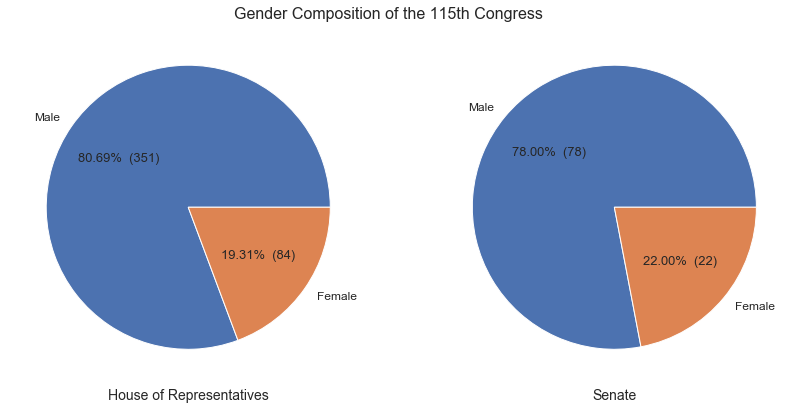

In [6]:
# Plot gender composition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,7))
fig.suptitle('Gender Composition of the 115th Congress', fontsize=16, y = .9)

house_gender = demo_df[demo_df['chamber']=='House']['gender'].value_counts()
house_gender.plot(kind='pie', ax=ax1, autopct = make_autopct(house_gender), colors=cmap)
ax1.set(xlabel = 'House of Representatives', ylabel = "")

senate_gender = demo_df[demo_df['chamber']=='Senate']['gender'].value_counts()
senate_gender.plot(kind='pie', ax=ax2, autopct = make_autopct(senate_gender), colors=cmap)
ax2.set(xlabel = 'Senate', ylabel = "")
sns.despine()

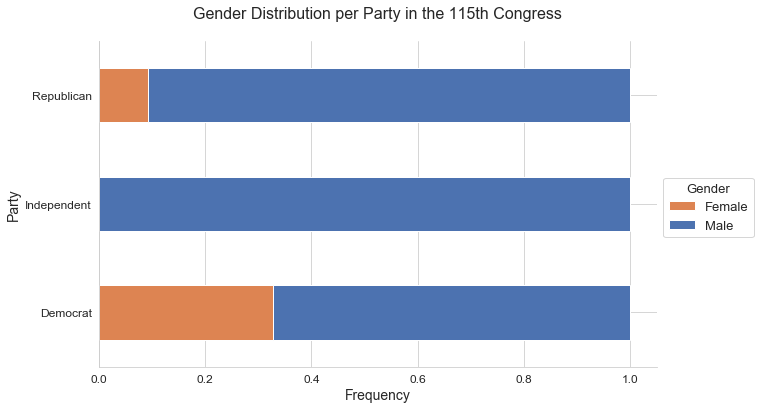

In [7]:
# Plot gender composition per party
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize = (10,6))
    gender_party = pd.crosstab(demo_df['party'], demo_df['gender'], normalize='index')
    gender_party.plot.barh(stacked='True', color=[cmap[1], cmap[0]], ax =ax)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Party')
    ax.set_yticklabels(['Democrat', 'Independent', 'Republican'])
    ax.legend(title = 'Gender', bbox_to_anchor=(1, .6))
    ax.set_title('Gender Distribution per Party in the 115th Congress', y = 1.05)
    sns.despine()

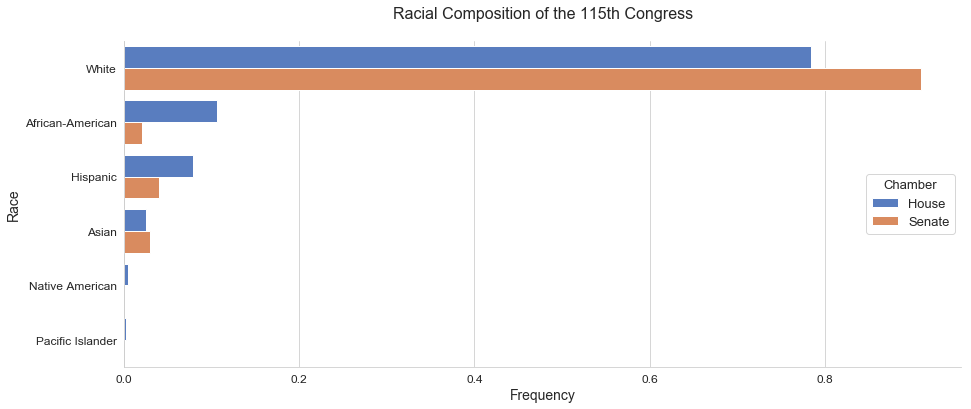

In [8]:
# Plot racial composition
race_counts = (demo_df.groupby(['chamber'])['race']
                     .value_counts(normalize=True)
                     .rename('frequency')
                     .reset_index())

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize = (15,6))
    sns.barplot(x='frequency', y='race', hue='chamber', data=race_counts)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Race')
    ax.legend(title = 'Chamber')
    ax.set_title('Racial Composition of the 115th Congress', y = 1.05)
    sns.despine()

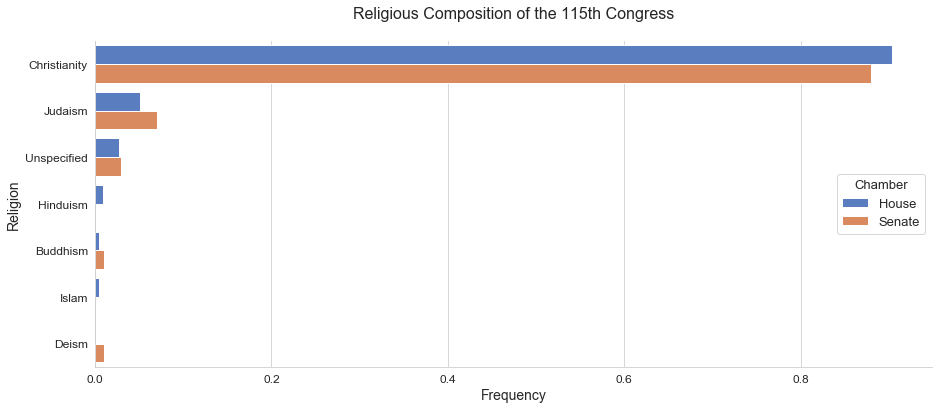

In [9]:
# Plot religious composition
religion_counts = (demo_df.groupby(['chamber'])['religion']
                     .value_counts(normalize=True)
                     .rename('frequency')
                     .reset_index())

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize = (15,6))
    sns.barplot(x='frequency', y='religion', hue='chamber', data=religion_counts)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Religion')
    ax.legend(title = 'Chamber')
    ax.set_title('Religious Composition of the 115th Congress', y = 1.05)
    sns.despine()

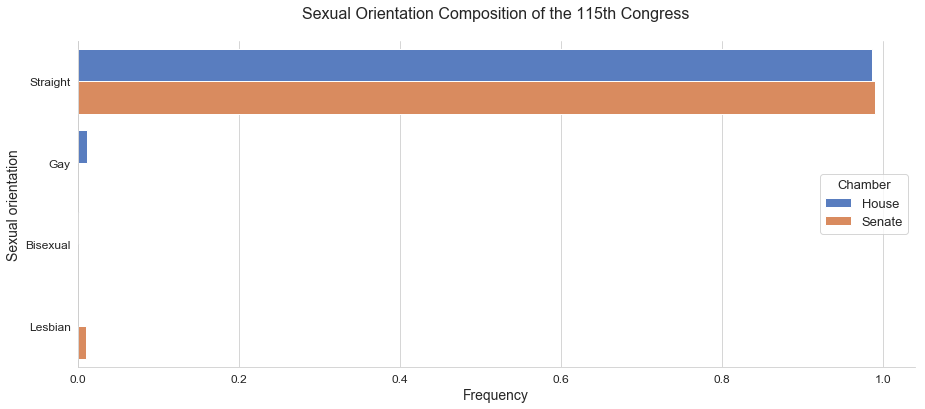

In [10]:
# Plot sexual orientation composition
lgbtq_counts = (demo_df.groupby(['chamber'])['openly_lgbtq']
                     .value_counts(normalize=True)
                     .rename('frequency')
                     .reset_index())

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize = (15,6))
    sns.barplot(x='frequency', y='openly_lgbtq', hue='chamber', data=lgbtq_counts)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Sexual orientation')
    ax.legend(title = 'Chamber', loc='center right')
    ax.set_title('Sexual Orientation Composition of the 115th Congress', y = 1.05)
    sns.despine()

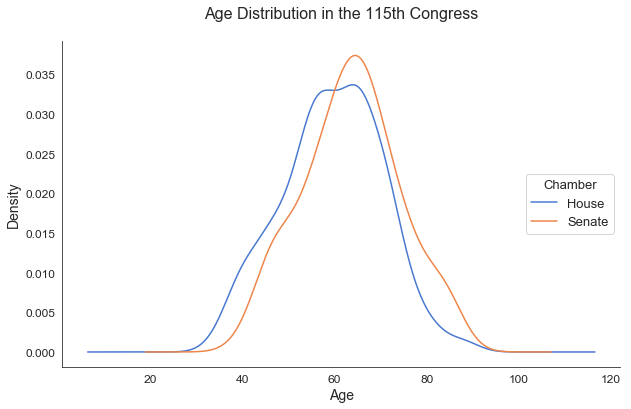

In [11]:
# Plot age distribution
fig, ax = plt.subplots(figsize = (10,6))
demo_df.groupby('chamber')['age'].plot(kind='kde')
ax.set_xlabel('Age')
ax.legend(title = 'Chamber', loc='center right')
ax.set_title('Age Distribution in the 115th Congress', y = 1.05)
sns.despine()

### Partisan Breakdown

In [12]:
demo_df.groupby(['chamber', 'party']).size().to_frame()

0
chamber party     
House   D      194
        R      241
Senate  D       47
        I        2
        R       51

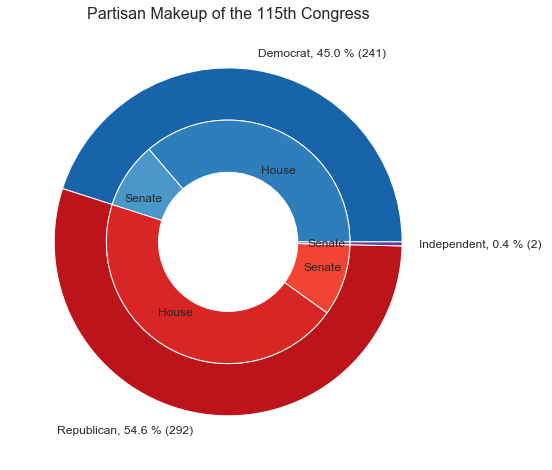

In [13]:
# Plot partisan makeup
fig, ax = plt.subplots(figsize = (8,8))

vals = np.array([[194, 47], [241, 51], [0, 2]])
outer_values = vals.sum(axis = 1)
party_labels = ['Democrat', 'Republican', 'Independent']
total = sum(outer_values)
outer_prct = [round(s/total*100, 2) for s in outer_values]
outer_labels = ['%s, %1.1f %% (%1.0f) ' % (l, p, s) for l, p, s in zip(party_labels, outer_prct, outer_values)]
inner_values = vals.flatten()
inner_labels = ['House', 'Senate', 'House', 'Senate', '', 'Senate']

# Colors
d, r, i = [plt.cm.Blues, plt.cm.Reds, plt.cm.Purples]
outer_colors = [d(.8), r(.8), i(.8)]
inner_colors = [d(.7), d(.6), r(.7), r(.6), i(.7), i(.7)]
size = 0.3 

# Outer pie
ax.pie(outer_values, radius = 1, labels = outer_labels, colors = outer_colors,  pctdistance = 0.8,
       wedgeprops = dict(width = size, edgecolor = 'white'))

# Inner pie
ax.pie(inner_values, radius = 1 - size, labels = inner_labels, labeldistance = .65 ,colors = inner_colors,
       wedgeprops = dict(width = size, edgecolor = 'white'))

ax.set(aspect="equal", title='Partisan Makeup of the 115th Congress')
sns.despine()

Text(0.5, 1.0, 'Congressional Majority per State in the 115th Congress (Continental U.S.)')

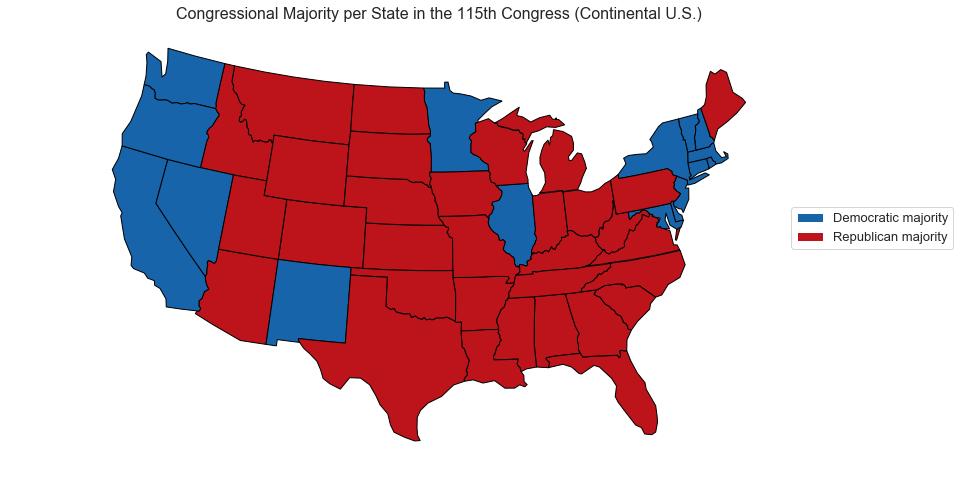

In [14]:
# Plot map of partisan congressional majority
ax = plt.axes([0, 0, 2, 2], projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

# Import geographic data
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)
geo_df = geopandas.read_file(states_shp)
geo_df = geo_df.filter(['name', 'geometry'])

majority_df = demo_df.groupby('state_name')['party'].apply(lambda x: x.mode()[0][0]).reset_index()
geo_df = (pd.merge(geo_df, majority_df, left_on='name', right_on='state_name', how='inner')
          .drop('state_name', axis=1))

# Style
d, r = [plt.cm.Blues, plt.cm.Reds]
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

# Color and draw each state
for state, geo, party in zip(geo_df['name'], geo_df['geometry'], geo_df['party']):
    facecolor = [0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
            
    if party == 'D':
        facecolor = d(.8)
    else:
        facecolor = r(.8)
    
    ax.add_geometries([geo], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor)
democrat = mpatches.Rectangle((0, 0), 1, 1, facecolor=d(.8))
republican = mpatches.Rectangle((0, 0), 1, 1, facecolor=r(.8))
labels = ['Democratic majority', 'Republican majority']
ax.legend([democrat, republican], labels, loc='lower left', bbox_to_anchor=(0.9, 0.5), fancybox=True)
ax.set_title('Congressional Majority per State in the 115th Congress (Continental U.S.)')

## k-Means Clustering

### Senate

In [15]:
# Import k-means algorithm and scaler
kmeans_model = KMeans(n_clusters = 2, random_state = 42, n_jobs = -1) # 2 clusters, for left and right-wing
min_max_scaler = MinMaxScaler()

In [16]:
# Fit k-means model
senate_distances = kmeans_model.fit_transform(senate_df.iloc[:, 8:])
senate_distances = min_max_scaler.fit_transform(senate_distances)

In [17]:
# Add results to Senate dataframe
senate_df['label'] = kmeans_model.labels_
senate_df['x_distance'] = senate_distances[:,0]
senate_df['y_distance'] = senate_distances[:,1]
pd.crosstab(senate_df['label'], senate_df['party'])

party,D,I,R
label,,,
0,0,0,53
1,48,2,0


**Findings:** All Republican and Democrat Senators vote in accordance with party lines. <br/>
Both independent Senators fall in line with Democrats.

In [18]:
# Add function to add labels to markers
def annotate(name, state, x, y, flip):
    label = name + ' (' + state + ')'
    plt.annotate(label,
                 xy = (x, y),
                 xytext = (7*flip, -2),
                 textcoords = 'offset points')

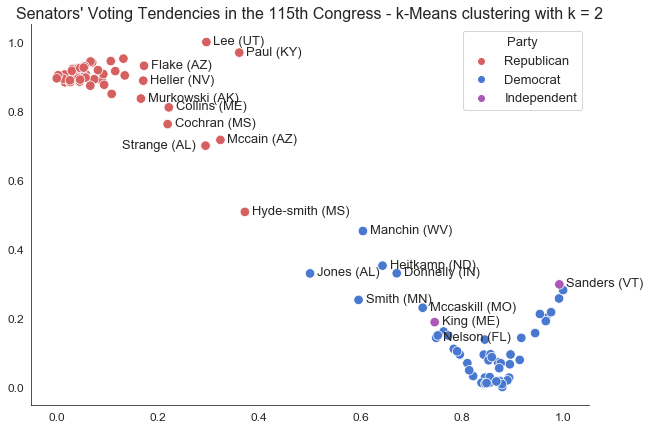

In [19]:
party_colors = {'D': 'C0', 'R': 'C3', 'I': '#ab59b6'}

# Plot Senate clusters
fig, ax = plt.subplots(figsize = (10,7))
sns.scatterplot(x = senate_df['x_distance'], y = senate_df['y_distance'], hue = senate_df['party'], 
                palette = party_colors, **{'s': 90}, ax=ax)
ax.set(title = "Senators' Voting Tendencies in the 115th Congress - k-Means clustering with k = 2",
       xlabel = '', ylabel = '')

#Add name labels for moderate senators and independents
senate_labels = (senate_df[((senate_df['x_distance'] > 0.16) & (senate_df['x_distance'] < 0.75)) 
                        | (senate_df['party'] == 'I')]
              .sort_values('y_distance', ascending = False))
for name, state, x, y in zip(senate_labels['last_name'], senate_labels['state_code'],
                             senate_labels['x_distance'], senate_labels['y_distance']):
    
    if name == "Strange":
        flip = -12
    else:
        flip = 1
    annotate(name, state, x, y, flip)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Republican', 'Democrat', 'Independent'], title='Party')
sns.despine()

**Findings:** Republican Senators tend to vote more similarly than Democrats. 

Certain Senators from opposing parties have voting records that are more similar than those of members from their own party, i.e. Hyde-Smith (R) and Manchin (D). This is unsurprising given that Hyde-Smith was a Democrat Senator until 2010.

Moderate Senators include: Flake (R), Collins (R), McCain (R), Heitkamp (D) and Jones (D).

### House of Representatives

In [20]:
# Import k-means algorithm and scaler
kmeans_model = KMeans(n_clusters = 2, random_state = 41, n_jobs = -1) # 2 clusters, for left and right-wing

In [21]:
# Fit k-means model
house_distances = kmeans_model.fit_transform(house_df.iloc[:, 8:])
house_distances = min_max_scaler.fit_transform(house_distances)

In [22]:
# Add results to House dataframe
house_df['label'] = kmeans_model.labels_
house_df['x_distance'] = house_distances[:,0]
house_df['y_distance'] = house_distances[:,1]
pd.crosstab(house_df['label'], house_df['party'])

party,D,R
label,,
0,0,242
1,195,0


**Findings:** All representatives vote according to their party affiliation.

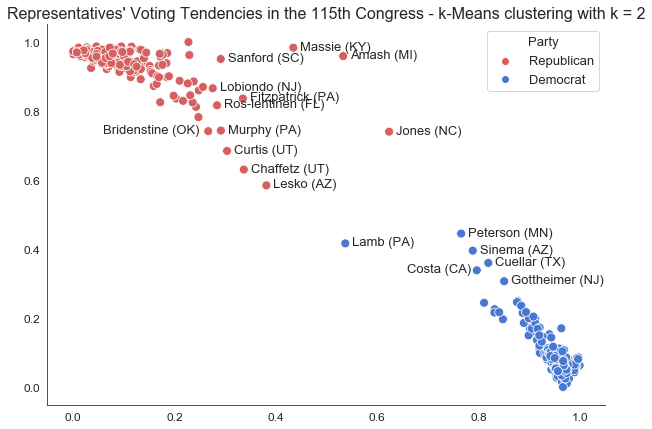

In [23]:
# Plot House clusters
fig, ax = plt.subplots(figsize = (10,7))
sns.scatterplot(x = house_df['x_distance'], y = house_df['y_distance'], hue = house_df['party'], 
                palette = party_colors, **{'s': 80})

#Add name labels for representatives removed from clusters' centers 
house_labels = (house_df[(house_df['x_distance'] > .26)  
                         & (house_df['y_distance'] > .25)]
              .sort_values('y_distance', ascending = False))
for name, state, x, y in zip(house_labels['last_name'], house_labels['state_code'], house_labels['x_distance'], 
                            house_labels['y_distance']):
    if name == 'Bridenstine':
        flip = -15
    elif name == 'Costa':
        flip = -10
    else:
        flip = 1
    annotate(name, state, x, y, flip)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Republican', 'Democrat'], title='Party')
ax.set(xlabel = '', 
       ylabel = '', 
       title = "Representatives' Voting Tendencies in the 115th Congress - k-Means clustering with k = 2")
sns.despine()

**Findings:** More Republican Representatives diverge from the voting record from members of their parties compared to Democrats.

Moderate Representatives include: Lesko (R), Jones (R), Lamb (D) and Peterson (D).

## Conclusion

**Insights:**

The 115th U.S. Congress is majority white, Christian, straight and male. Most members are between 50 and 70 years old. While less than 10% of Republican members of Congress are female, there are more than 30% of female Democrat members. 

Congress is currently controlled by Republicans, who hold a 55% majority. Only 2 out of 535 members are Independent.

All members of Congress vote in accordance with party lines and Independents fall in line with Democrats. 

In the Senate, Republican vote more cohesively than Democrats, though a few are moderate such as Hyde-Smith and McCain.

In the House, Democrats vote with more cohesiveness than their counterparts from the Senate.

**Future work:**

Conduct a similar analysis after the 2018 midterm elections to compare the evolution of both Congress' composition and voting record.